In [1]:
from google.colab import files
uploaded = files.upload()

Saving listingsChicago.csv to listingsChicago.csv
Saving reviewsChicago.csv to reviewsChicago.csv


In [2]:
import pandas as pd
from sklearn.utils import resample
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from bs4 import BeautifulSoup
import re

listings = pd.read_csv(io.BytesIO(uploaded['listingsChicago.csv']))
reviews = pd.read_csv(io.BytesIO(uploaded['reviewsChicago.csv']))

# Data Cleaning

Checking all the attributes in the daatset


In [3]:
print(listings.columns)
print(reviews.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

Removing unnecessary attributes from the daatset

In [4]:
#Before Dropping
print(listings.shape)

listings = listings.drop(['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'calendar_updated','license','calendar_last_scraped'], axis=1)

#After dropping
print(listings.shape)

(7952, 75)
(7952, 59)


Price column has \$ symbol and cannot be processed as a numerical column. So, removing the \$ sign and converting it to float

In [5]:
# Ensure that the 'price' column is treated as a string first
listings['price'] = listings['price'].astype(str)

# Remove the $ symbol and commas using regex, then convert to numeric
listings['price'] = listings['price'].str.replace(r'[$,]', '', regex=True)

# Convert the cleaned 'price' column to a numeric type
listings['price'] = pd.to_numeric(listings['price'], errors='coerce')

# Check the result
print(listings['price'].head())
print(listings['price'].dtype)

0    103.0
1    169.0
2    128.0
3     96.0
4    315.0
Name: price, dtype: float64
float64


Checking if any of the numerical attributes have string or text data

In [6]:
# Convert the specified columns to numeric, coerce errors to NaN
cols_to_check = ['price','minimum_nights','maximum_nights','number_of_reviews','bedrooms', 'bathrooms', 'beds', 'accommodates',
                 'availability_30', 'availability_365', 'number_of_reviews_ltm','review_scores_rating']

# Function to check if values are non-numeric
def count_non_numeric(series):
    # This will return True for non-numeric values (strings or text)
    return series.apply(pd.to_numeric, errors='coerce').isna().sum()

# Apply the function to each column and get the count of non-numeric rows per column
non_numeric_counts = listings[cols_to_check].apply(count_non_numeric)

# Output the result
print("Number of rows with non-numeric values for each column:")
print(non_numeric_counts)



Number of rows with non-numeric values for each column:
price                     354
minimum_nights              0
maximum_nights              0
number_of_reviews           0
bedrooms                   87
bathrooms                 355
beds                      403
accommodates                0
availability_30             0
availability_365            0
number_of_reviews_ltm       0
review_scores_rating     1449
dtype: int64


Cleaning the text attributes room_type

In [7]:
# Remove leading/trailing spaces
listings['room_type'] = listings['room_type'].str.strip()

# Standardize text to lowercase
listings['room_type'] = listings['room_type'].str.lower()


Checking for missing values in the text attributes room_type and neighbourhood_cleansed

In [8]:
import pandas as pd

# Specify the columns to check for missing values
columns_to_check = ['room_type', 'neighbourhood_cleansed']

# Get the count of missing values for the specified columns
missing_values = listings[columns_to_check].isnull().sum()

# Display the number of missing values for these columns
print(missing_values)


room_type                 0
neighbourhood_cleansed    0
dtype: int64


Converting the amenities in each row into a numerical attribute in order to be used for further analysis.

In [9]:
# Function to clean and count the number of amenities in each record
def count_amenities(amenities_str):
    # Decode special characters and remove unnecessary characters like quotes, square brackets, etc.
    cleaned_amenities_str = amenities_str.encode('utf-8').decode('unicode_escape').strip('[]').replace('"', '')

    # Split the cleaned string into a list of amenities
    amenities_list = cleaned_amenities_str.split(', ')

    # Return the count of amenities
    return len(amenities_list)

# Apply the function to each record in the 'amenities' column
listings['amenities_count'] = listings['amenities'].apply(lambda x: count_amenities(x))

# Display the updated DataFrame with the new column
print(listings[['amenities', 'amenities_count']])

                                              amenities  amenities_count
0     ["Shampoo", "Dedicated workspace", "Wifi", "Pr...               35
1     ["Shampoo", "Dining table", "Window AC unit", ...               38
2     ["Shampoo", "Wifi", "Bed linens", "Freezer", "...               29
3     ["Shampoo", "Ethernet connection", "Dedicated ...               34
4     ["Crib - always at the listing", "Shampoo", "D...               52
...                                                 ...              ...
7947  ["Fire extinguisher", "Air conditioning", "Ded...               10
7948  ["Shampoo", "Indoor fireplace: gas", "Ethernet...               53
7949  ["Shampoo", "Theme room", "Shared sauna", "Eth...               58
7950  ["Ethernet connection", "Dining table", "Cloth...               47
7951  ["Shampoo", "Dining table", "Dedicated workspa...               42

[7952 rows x 2 columns]


# Descriptive Statistics

Calculate summary statistics for numerical features such as `price`,
`minimum_nights`, `maximum_nights`, `number_of_reviews`, and
`review_scores_rating`. Understand the central tendency, dispersion, and
distribution of these variables.

In [10]:
# List of numerical features to analyze
numerical_features = ['price','minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating']

# Additional features for analysis
additional_numerical_features = ['accommodates','availability_30', 'availability_365', 'number_of_reviews_ltm']

Removing null values from the required numerical features

In [11]:
# Convert columns to numeric, invalid parsing will be set as NaN
listings[numerical_features] = listings[numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
listings_1 = listings.dropna(subset=numerical_features)

# Check the DataFrame to ensure non-numeric values have been removed
print(listings_1)

# Verify that all specified columns are numerical
print(listings_1[numerical_features].dtypes)

                       id                                               name  \
0                16757056                     Heart of Chicago 2BD + Parking   
1                48112045  West Town Chicago Apt near Metra and United Ce...   
2     1089958767588000931                    Nice 2bd 1ba w/ gated entrance!   
3                24694181                                         Talman Ave   
4      639920368906600737      Historic brownstone in the heart of Old Town!   
...                   ...                                                ...   
7945             48103490                        GLORIOUS GOLD COAST GETAWAY   
7946   916658122724773865  #5Ecomfy and convenient room&Shared bath in Up...   
7948   737600228577337279  Spacious & New Modern-Chic Condo Close to Down...   
7950             51198174   Lovely 1 Bedroom apartment near downtown chicago   
7951   678998149626085566            1BR Deluxe Apartment near Shops & Cafés   

                                       

Calculating the summary statistics for the required numerical values

In [12]:
def display_summary_statistics(dataframe, numerical_features):
    # Calculate summary statistics
    summary_statistics = dataframe[numerical_features].describe()

    # Display the summary statistics
    print("Summary Statistics:")
    print(summary_statistics)

numerical_features = ['price', 'minimum_nights','maximum_nights', 'review_scores_rating']
display_summary_statistics(listings_1, numerical_features)


Summary Statistics:
             price  minimum_nights  maximum_nights  review_scores_rating
count  6241.000000     6241.000000     6241.000000           6241.000000
mean    216.958660        9.887838      493.391283              4.761828
std     218.019122       21.179277      434.509426              0.402229
min      19.000000        1.000000        2.000000              1.000000
25%      99.000000        1.000000       90.000000              4.710000
50%     159.000000        2.000000      365.000000              4.860000
75%     255.000000        5.000000     1125.000000              4.980000
max    2911.000000      365.000000     1125.000000              5.000000


Removing null values from the additional numerical features

In [13]:
# Convert columns to numeric, invalid parsing will be set as NaN
listings[additional_numerical_features] = listings[additional_numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
listings_2 = listings.dropna(subset=additional_numerical_features)

# Check the DataFrame to ensure non-numeric values have been removed
print(listings_2)

# Verify that all specified columns are numerical
print(listings_2[additional_numerical_features].dtypes)

                       id                                               name  \
0                16757056                     Heart of Chicago 2BD + Parking   
1                48112045  West Town Chicago Apt near Metra and United Ce...   
2     1089958767588000931                    Nice 2bd 1ba w/ gated entrance!   
3                24694181                                         Talman Ave   
4      639920368906600737      Historic brownstone in the heart of Old Town!   
...                   ...                                                ...   
7947  1000697794721640829                     Downtown Chicago Humble Abode!   
7948   737600228577337279  Spacious & New Modern-Chic Condo Close to Down...   
7949   866318429557340926                      Downtown Luxury Top Floor Apt   
7950             51198174   Lovely 1 Bedroom apartment near downtown chicago   
7951   678998149626085566            1BR Deluxe Apartment near Shops & Cafés   

                                       

Calculating the summary statistics for the additional numerical features

In [14]:
display_summary_statistics(listings_2, additional_numerical_features)

Summary Statistics:
             price  minimum_nights  maximum_nights  review_scores_rating
count  7598.000000     7952.000000     7952.000000           6503.000000
mean    225.515399       14.094693      517.251509              4.759703
std     245.570005       26.696324      431.938813              0.412168
min      13.000000        1.000000        2.000000              1.000000
25%     100.000000        2.000000       95.000000              4.710000
50%     166.000000        2.000000      365.000000              4.860000
75%     266.000000       32.000000     1125.000000              4.980000
max    5120.000000      365.000000     1125.000000              5.000000


Calculating the values variance, skewness, kurtosis for understanding the central tendency, dispersion

In [15]:
# Calculate variance
variance_values1 = listings_1[numerical_features].var()
variance_values2 = listings_2[additional_numerical_features].var()
print("\nVariance Values:")
print(variance_values1)
print(variance_values2)

# Calculate skewness
skewness_values1 = listings_1[numerical_features].skew()
skewness_values2 = listings_2[additional_numerical_features].skew()
print("\nSkewness Values:")
print(skewness_values1)
print(skewness_values2)

# Calculate kurtosis
kurtosis_values1 = listings_1[numerical_features].kurt()
kurtosis_values2 = listings_2[additional_numerical_features].kurt()
print("\nKurtosis Values:")
print(kurtosis_values1)
print(kurtosis_values2)


Variance Values:
price                    47532.337714
minimum_nights             448.561777
maximum_nights          188798.441424
review_scores_rating         0.161788
dtype: float64
accommodates                 9.293594
availability_30            102.460558
availability_365         12602.604372
number_of_reviews_ltm      466.226174
dtype: float64

Skewness Values:
price                   4.410585
minimum_nights          9.389367
maximum_nights          0.549190
review_scores_rating   -5.368894
dtype: float64
accommodates             1.651851
availability_30          0.531010
availability_365        -0.278825
number_of_reviews_ltm    6.872018
dtype: float64

Kurtosis Values:
price                    31.927732
minimum_nights          140.121533
maximum_nights           -1.329649
review_scores_rating     40.125470
dtype: float64
accommodates               3.038875
availability_30           -1.066089
availability_365          -1.203309
number_of_reviews_ltm    108.715241
dtype: float64


# 2. Distribution Analysis

Plot histograms or density plots for key numerical features like price,minimum_nights, and review_scores_rating. Analyze the distribution of these features to identify any skewness or outliers.

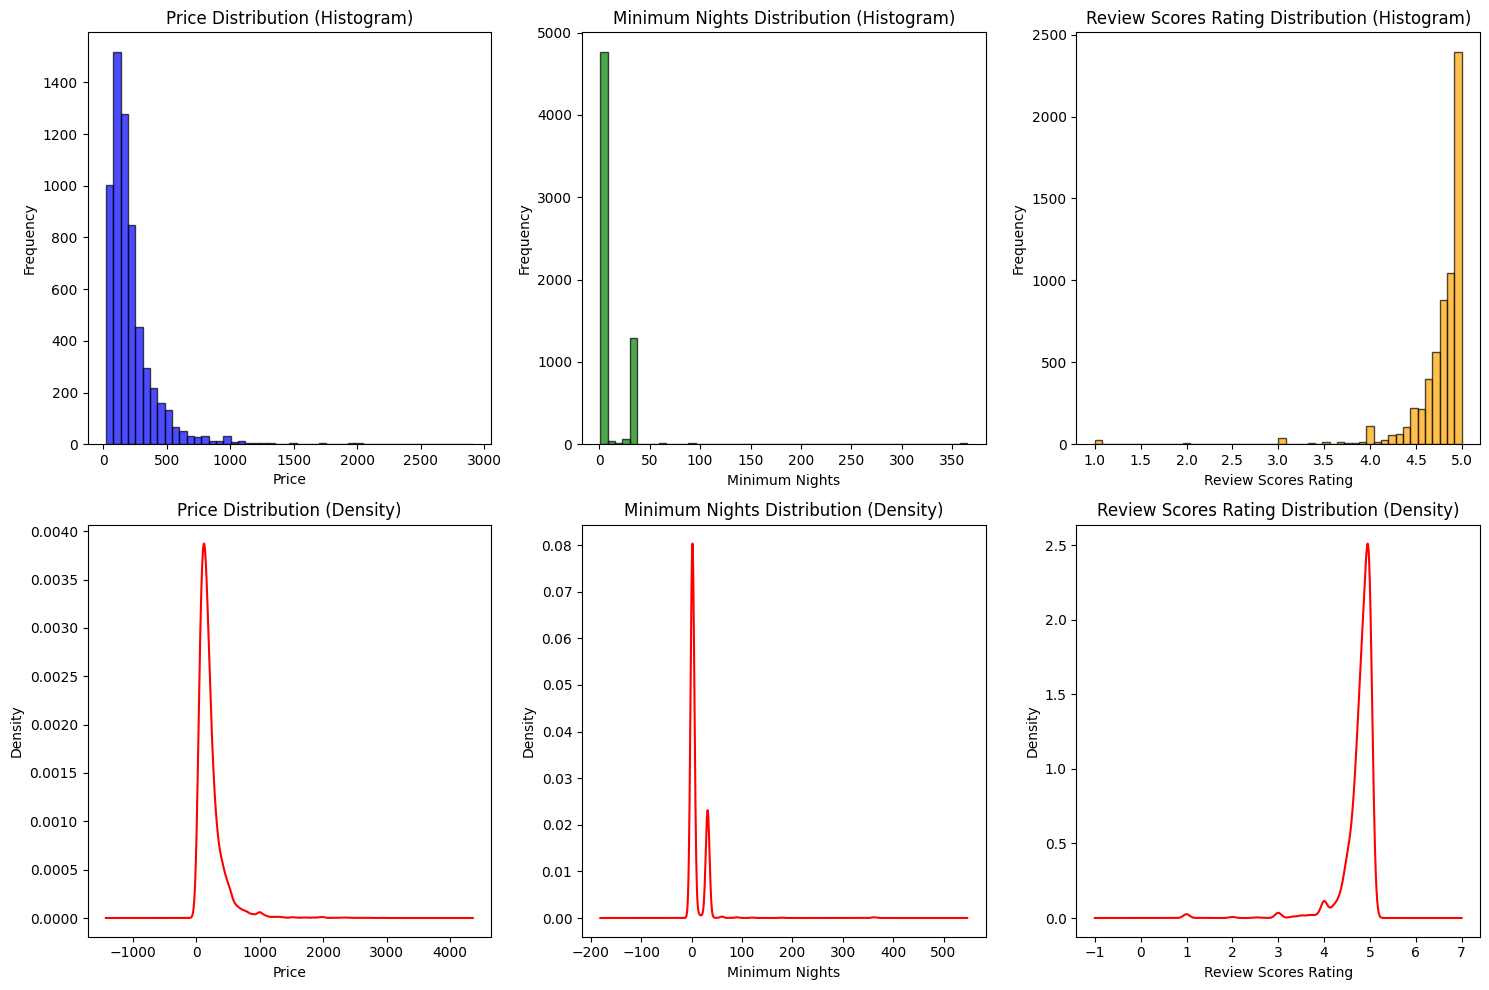

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_numerical_distributions(dataframe):
    """
    Plot histograms and density plots for key numerical features in the DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the numerical features.
    """
    plt.figure(figsize=(15, 10))

    # Price histogram
    plt.subplot(2, 3, 1)
    plt.hist(dataframe['price'], bins=50, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Price Distribution (Histogram)')
    plt.xlabel('Price')
    plt.ylabel('Frequency')

    # Price density plot
    plt.subplot(2, 3, 4)
    dataframe['price'].plot(kind='kde', color='red')
    plt.title('Price Distribution (Density)')
    plt.xlabel('Price')
    plt.ylabel('Density')

    # Minimum nights histogram
    plt.subplot(2, 3, 2)
    plt.hist(dataframe['minimum_nights'], bins=50, color='green', edgecolor='black', alpha=0.7)
    plt.title('Minimum Nights Distribution (Histogram)')
    plt.xlabel('Minimum Nights')
    plt.ylabel('Frequency')

    # Minimum nights density plot
    plt.subplot(2, 3, 5)
    dataframe['minimum_nights'].plot(kind='kde', color='red')
    plt.title('Minimum Nights Distribution (Density)')
    plt.xlabel('Minimum Nights')
    plt.ylabel('Density')

    # Review scores rating histogram
    plt.subplot(2, 3, 3)
    plt.hist(dataframe['review_scores_rating'].dropna(), bins=50, color='orange', edgecolor='black', alpha=0.7)
    plt.title('Review Scores Rating Distribution (Histogram)')
    plt.xlabel('Review Scores Rating')
    plt.ylabel('Frequency')

    # Review scores rating density plot
    plt.subplot(2, 3, 6)
    dataframe['review_scores_rating'].dropna().plot(kind='kde', color='red')
    plt.title('Review Scores Rating Distribution (Density)')
    plt.xlabel('Review Scores Rating')
    plt.ylabel('Density')

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_numerical_distributions(listings_1)


# 3. Correlation Analysis

Create a correlation matrix to explore relationships between numerical variables such as price, number_of_reviews, availability_365, and review_scores_rating. Identify any strong correlations that might be useful for predictive modeling or further investigation.

Plotting correlation matrix and heatmap for the required attributes

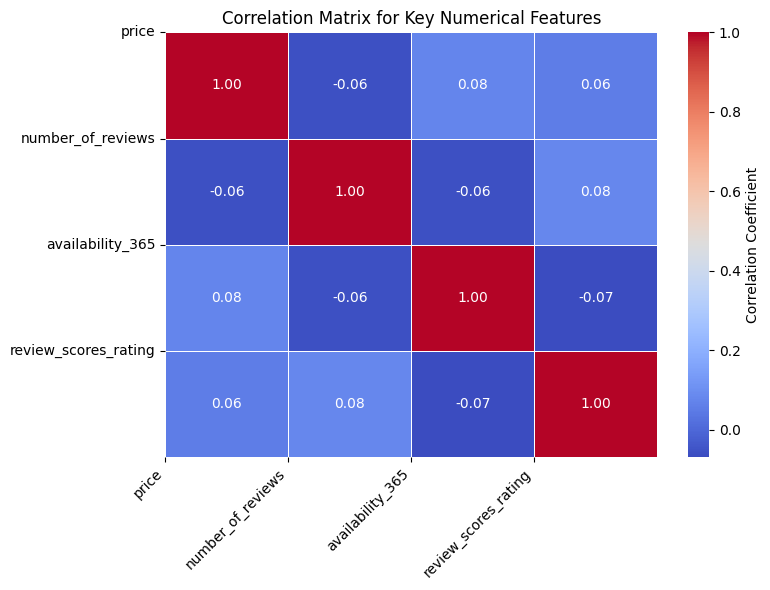

,price,number_of_reviews,availability_365,review_scores_rating
price,1.000000,-0.059792,0.075601,0.055803
number_of_reviews,-0.059792,1.000000,-0.059970,0.080503
availability_365,0.075601,-0.059970,1.000000,-0.069375
review_scores_rating,0.055803,0.080503,-0.069375,1.000000


In [17]:
#List of columns
correlation_columns = ['price', 'number_of_reviews', 'availability_365', 'review_scores_rating']

# Convert columns to numeric, invalid parsing will be set as NaN
listings[correlation_columns] = listings[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns
listings_3 = listings_1.dropna(subset=correlation_columns)

# Creating the correlation matrix
correlation_matrix = listings_3[correlation_columns].corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix

Plotting correlation matrix and heatmap for additional attributes

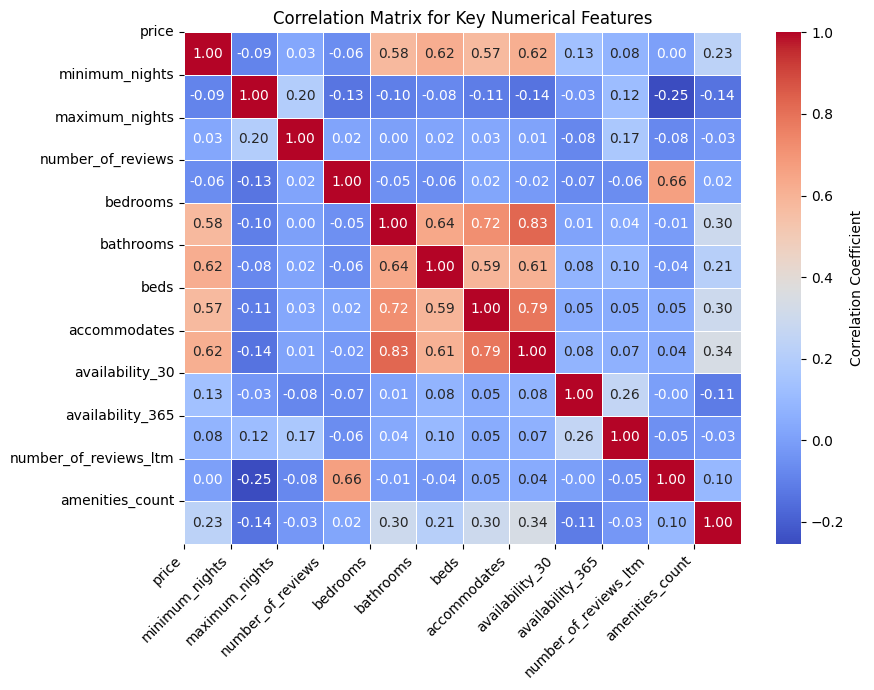

,price,minimum_nights,maximum_nights,number_of_reviews,bedrooms,bathrooms,beds,accommodates,availability_30,availability_365,number_of_reviews_ltm,amenities_count
price,1.000000,-0.090364,0.029566,-0.059100,0.575171,0.620638,0.569239,0.616787,0.134980,0.077637,0.004677,0.234337
minimum_nights,-0.090364,1.000000,0.199340,-0.131701,-0.103016,-0.075978,-0.111775,-0.138388,-0.025434,0.116901,-0.253979,-0.136748
maximum_nights,0.029566,0.199340,1.000000,0.018203,0.003081,0.017214,0.028050,0.011303,-0.082107,0.168069,-0.077258,-0.026454
number_of_reviews,-0.059100,-0.131701,0.018203,1.000000,-0.050472,-0.059071,0.024285,-0.017671,-0.068028,-0.061853,0.662209,0.022058
bedrooms,0.575171,-0.103016,0.003081,-0.050472,1.000000,0.640869,0.718744,0.827201,0.014124,0.035251,-0.009882,0.298761
bathrooms,0.620638,-0.075978,0.017214,-0.059071,0.640869,1.000000,0.588752,0.605940,0.077569,0.099849,-0.035853,0.211806
beds,0.569239,-0.111775,0.028050,0.024285,0.718744,0.588752,1.000000,0.789165,0.049459,0.046560,0.046776,0.296326
accommodates,0.616787,-0.138388,0.011303,-0.017671,0.827201,0.605940,0.789165,1.000000,0.075863,0.066983,0.040240,0.342244
availability_30,0.134980,-0.025434,-0.082107,-0.068028,0.014124,0.077569,0.049459,0.075863,1.000000,0.257859,-0.003185,-0.113328
availability_365,0.077637,0.116901,0.168069,-0.061853,0.035251,0.099849,0.046560,0.066983,0.257859,1.000000,-0.052549,-0.025424


In [18]:
#List of columns
correlation_columns = ['price','minimum_nights','maximum_nights','number_of_reviews','bedrooms','bathrooms','beds','accommodates','availability_30','availability_365','number_of_reviews_ltm','amenities_count']

# Convert columns to numeric, invalid parsing will be set as NaN
listings[correlation_columns] = listings[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns
listings_4 = listings_1.dropna(subset=correlation_columns)

# Creating the correlation matrix
correlation_matrix = listings_4[correlation_columns].corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix


# 4. Price Analysis

Analyze the distribution of prices across different neighborhoods (host_neighbourhood) or room types (if available). Understand which neighborhoods have higher or lower average prices and whether certain neighborhoods are more popular for shortterm or longterm stays.

In [19]:
listings['stay_type'] = listings['minimum_nights'].apply(lambda x: 'Long-term' if x > 30 else 'Short-term')

# Extracting relevant columns for price analysis: price, neighbourhood_cleansed, room_type, and minimum_nights
price_analysis_columns = ['price', 'neighbourhood_cleansed', 'room_type', 'minimum_nights', 'maximum_nights', 'stay_type']

# Creating the price_analysis_data DataFrame
price_analysis_data = listings[price_analysis_columns].dropna()

# Calculating average price per neighborhood
avg_price_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

# Calculating average minimum/maximum nights per neighborhood (to understand short-term vs long-term stays)
avg_minimum_nights_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['minimum_nights'].mean().sort_values(ascending=False)
avg_maximum_nights_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['maximum_nights'].mean().sort_values(ascending=False)

# Calculating average price per room type
avg_price_room_type = price_analysis_data.groupby('room_type')['price'].mean().sort_values(ascending=False)

# Calculate average price for short-term and long-term stays by neighborhood
avg_price_neighbourhood_stay_type = price_analysis_data.groupby(['neighbourhood_cleansed', 'stay_type'])['price'].mean().unstack().fillna(0)

# Calculate average price for short-term and long-term stays by room type
avg_price_room_type_stay_type = price_analysis_data.groupby(['room_type', 'stay_type'])['price'].mean().unstack().fillna(0)

# Displaying the results
print("Average Price by Neighborhood:")
print(avg_price_neighbourhood)

print("\nAverage Minimum Nights by Neighborhood:")
print(avg_minimum_nights_neighbourhood)

print("\nAverage Maximum Nights by Neighborhood:")
print(avg_maximum_nights_neighbourhood)

print("\nAverage Price by Room Type:")
print(avg_price_room_type)

print("\nAverage Price by Neighborhood and Stay Type:")
print(avg_price_neighbourhood_stay_type)

print("\nAverage Price by Room Type and Stay Type:")
print(avg_price_room_type_stay_type)


Average Price by Neighborhood:
neighbourhood_cleansed
Near North Side    355.829352
Loop               329.756818
Mount Greenwood    303.000000
Clearing           297.888889
West Town          297.585714
                      ...    
Riverdale           77.000000
West Englewood      76.208333
Englewood           74.589744
New City            63.432432
East Side           63.166667
Name: price, Length: 77, dtype: float64

Average Minimum Nights by Neighborhood:
neighbourhood_cleansed
West Pullman       48.400000
West Elsdon        32.000000
Riverdale          32.000000
Clearing           32.000000
West Lawn          24.769231
                     ...    
Morgan Park         4.700000
Armour Square       4.654321
Roseland            3.866667
Archer Heights      2.000000
Mount Greenwood     1.500000
Name: minimum_nights, Length: 77, dtype: float64

Average Maximum Nights by Neighborhood:
neighbourhood_cleansed
Gage Park             927.500000
Garfield Ridge        881.875000
Hegewisch     

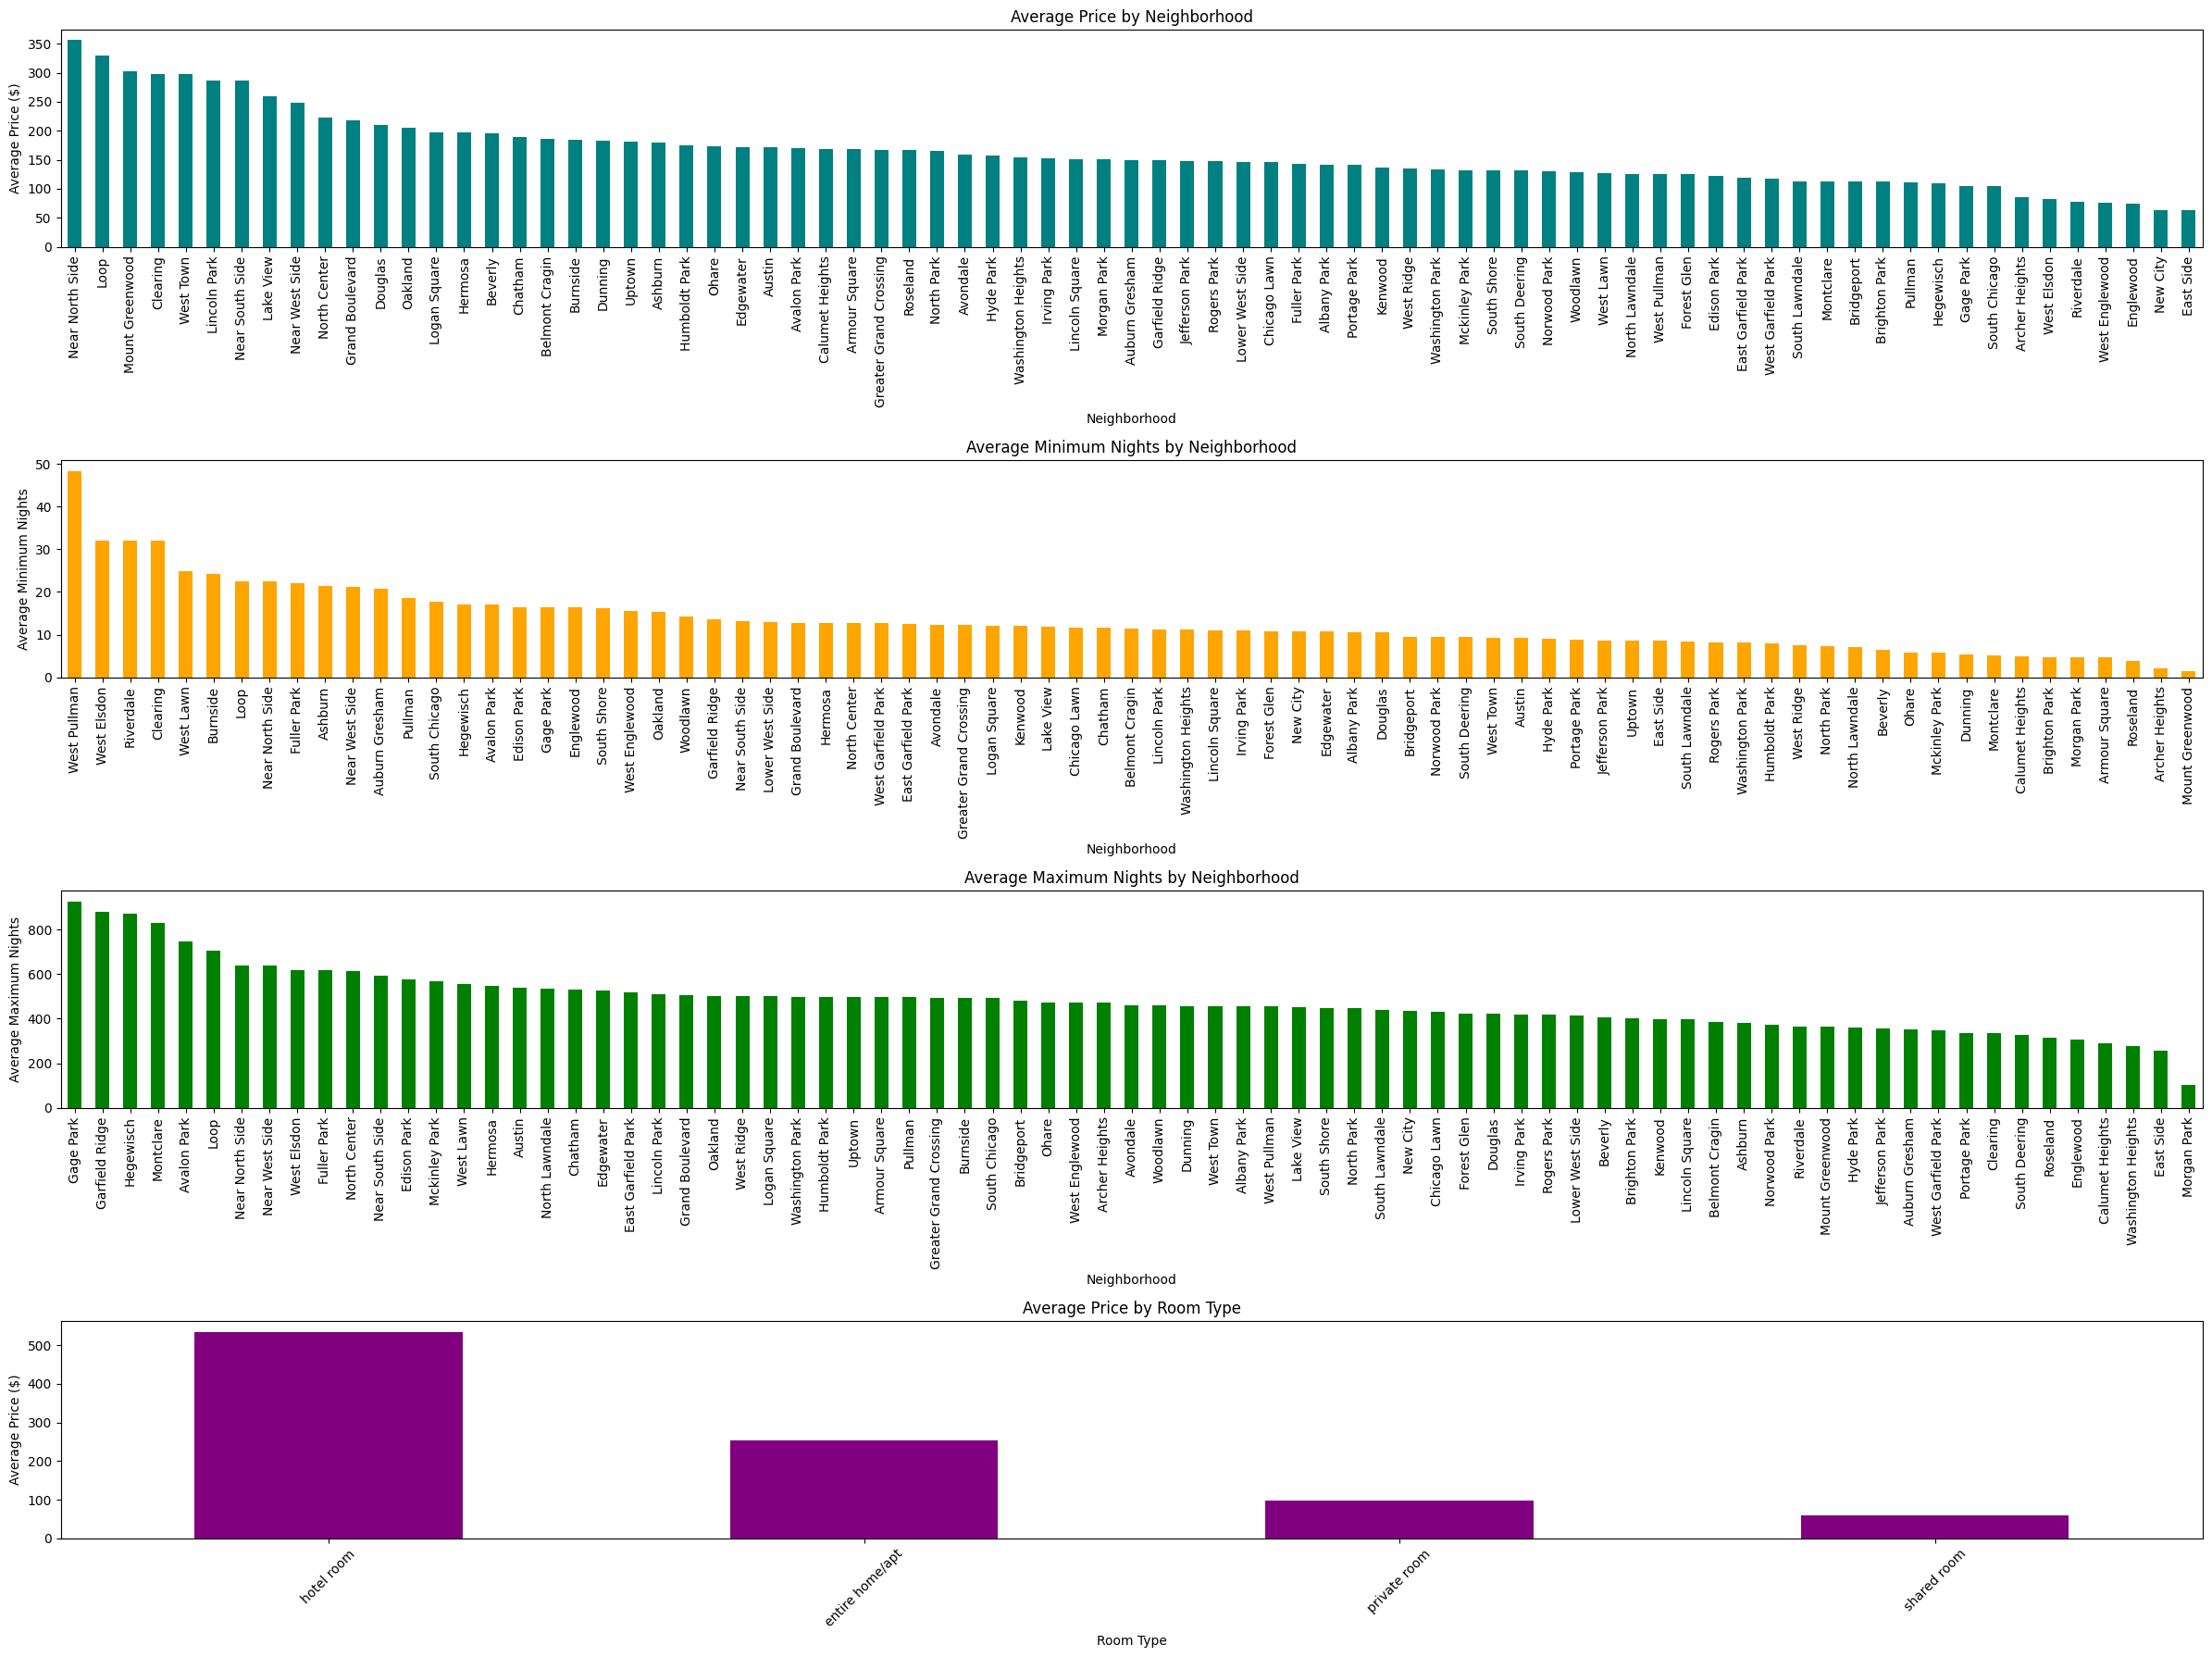

In [20]:
# Plotting price and minimum nights distributions across neighborhoods and room types
plt.figure(figsize=(24, 18))

# Average price by neighborhood
plt.subplot(4, 1, 1)
avg_price_neighbourhood.plot(kind='bar', color='teal')
plt.title('Average Price by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=90)

# Average minimum nights by neighborhood
plt.subplot(4, 1, 2)
avg_minimum_nights_neighbourhood.plot(kind='bar', color='orange')
plt.title('Average Minimum Nights by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Minimum Nights')
plt.xticks(rotation=90)

# Average maximum nights by neighborhood
plt.subplot(4, 1, 3)
avg_maximum_nights_neighbourhood.plot(kind='bar', color='green')
plt.title('Average Maximum Nights by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Maximum Nights')
plt.xticks(rotation=90)

# Average price by room type
plt.subplot(4, 1, 4)
avg_price_room_type.plot(kind='bar', color='purple')
plt.title('Average Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


<Figure size 1600x800 with 0 Axes>

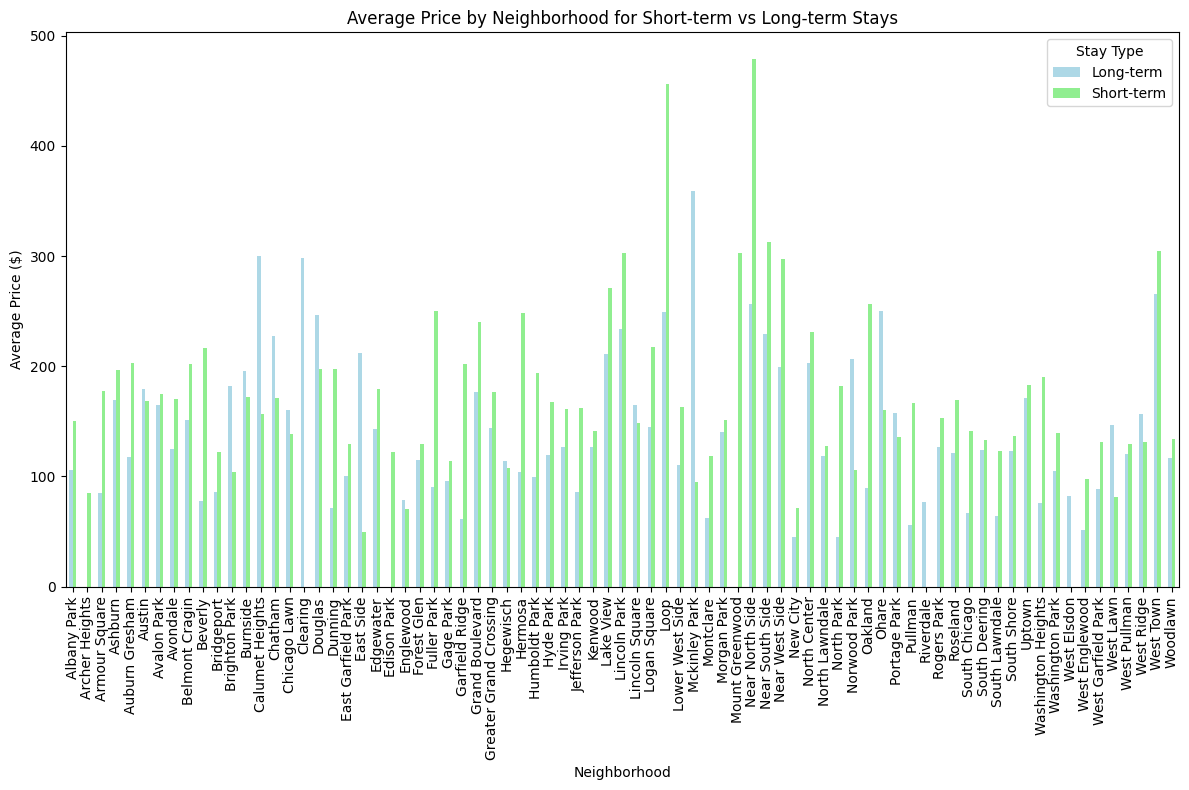

<Figure size 800x600 with 0 Axes>

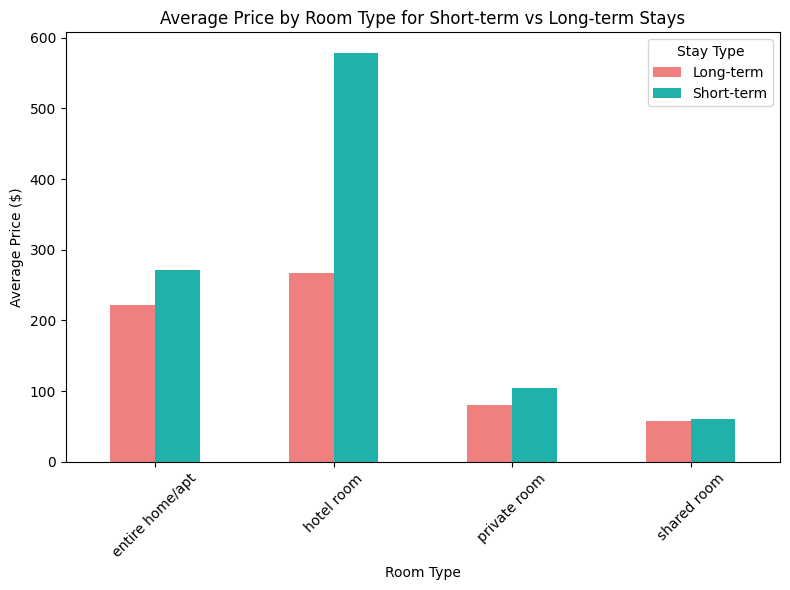

In [21]:
# Plotting average price by neighborhood for short-term and long-term stays
plt.figure(figsize=(16, 8))

# Average price by neighborhood for short-term and long-term stays
avg_price_neighbourhood_stay_type.plot(kind='bar', stacked=False, color=['lightblue', 'lightgreen'], figsize=(12, 8))
plt.title('Average Price by Neighborhood for Short-term vs Long-term Stays')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=90)
plt.legend(title='Stay Type')

plt.tight_layout()
plt.show()

# Plotting average price by room type for short-term and long-term stays
plt.figure(figsize=(8, 6))

# Average price by room type for short-term and long-term stays
avg_price_room_type_stay_type.plot(kind='bar', stacked=False, color=['lightcoral', 'lightseagreen'], figsize=(8, 6))
plt.title('Average Price by Room Type for Short-term vs Long-term Stays')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.legend(title='Stay Type')

plt.tight_layout()
plt.show()

# 5. Neighborhood Comparison

Compare the average review_scores_rating across different neighborhoods. Determine if certain neighborhoods have consistently higher ratings, which could indicate better or worse guest experiences.

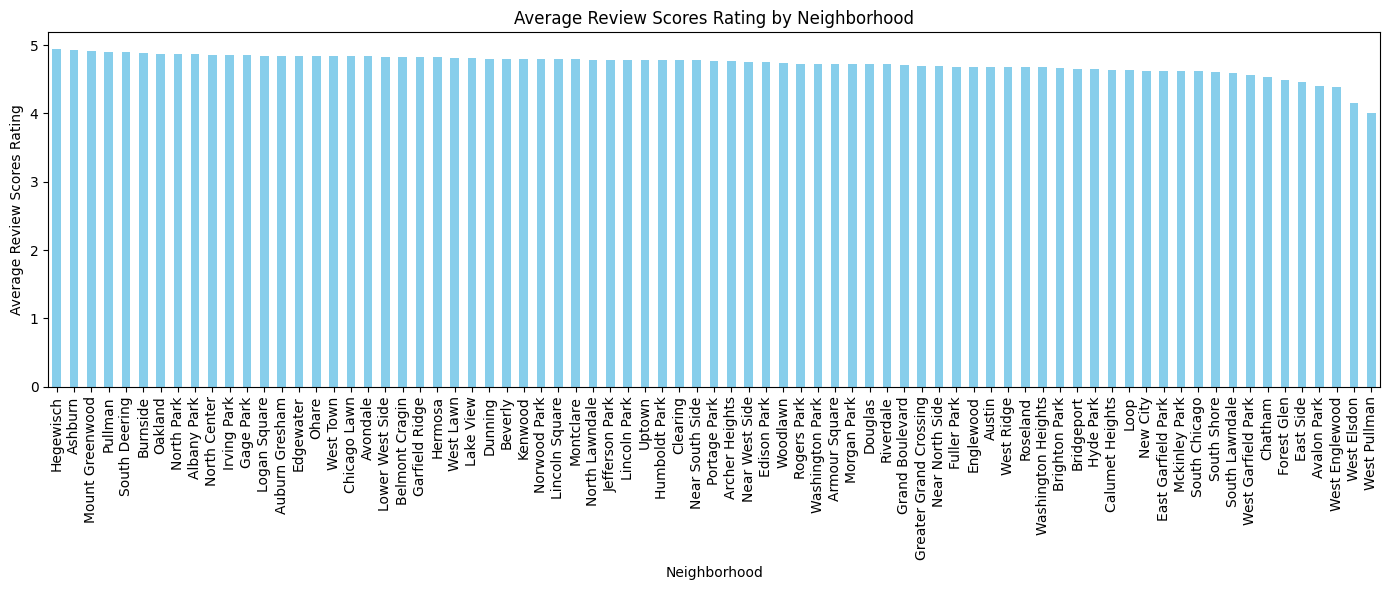

Average Review Scores Rating by Neighborhood:
neighbourhood_cleansed
Hegewisch          4.940000
Ashburn            4.930000
Mount Greenwood    4.910000
Pullman            4.905000
South Deering      4.900000
                     ...   
East Side          4.455833
Avalon Park        4.400000
West Englewood     4.392778
West Elsdon        4.155000
West Pullman       3.998750
Name: review_scores_rating, Length: 77, dtype: float64


In [22]:
# Calculating average review_scores_rating per neighborhood
avg_rating_neighbourhood = listings.groupby('neighbourhood_cleansed')['review_scores_rating'].mean().dropna().sort_values(ascending=False)

# Plotting the average review_scores_rating across neighborhoods
plt.figure(figsize=(14, 6))
avg_rating_neighbourhood.plot(kind='bar', color='skyblue')
plt.title('Average Review Scores Rating by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Review Scores Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Display the average review scores rating per neighborhood
print("Average Review Scores Rating by Neighborhood:")
print(avg_rating_neighbourhood)

# 6. Outlier Detection

Identify outliers in the dataset, particularly in price, minimum_nights, and review_scores_rating.

# Detecting outliers using IQR

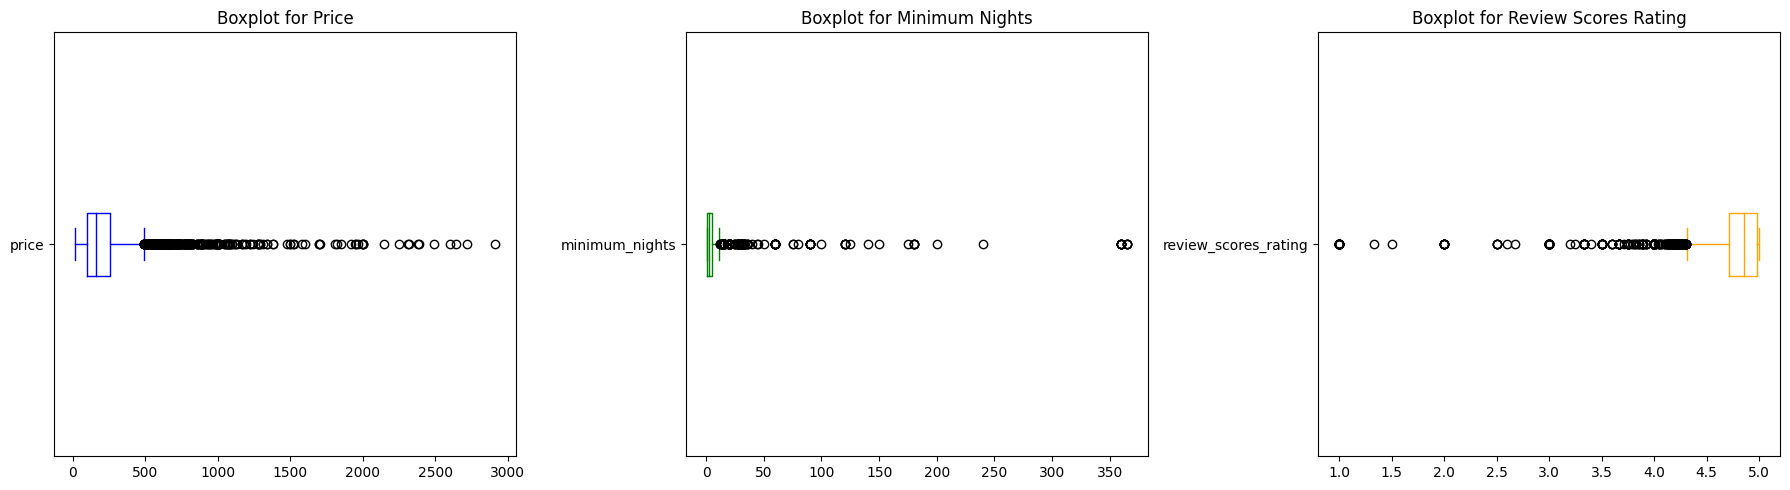

Number of price outliers: 451
       price
97    1342.0
99     599.0
119    550.0
127    563.0
131    759.0
...      ...
7862   662.0
7879   804.0
7916  2643.0
7933   717.0
7940   651.0

[451 rows x 1 columns]

Number of minimum nights outliers: 1457
      minimum_nights
6                 31
7                180
13                32
22                32
30                32
...              ...
7902              32
7911              32
7936              32
7939              32
7944              32

[1457 rows x 1 columns]

Number of review scores rating outliers: 377
      review_scores_rating
29                    1.00
33                    1.00
37                    3.60
52                    1.00
66                    4.07
...                    ...
7870                  4.00
7874                  3.33
7898                  4.00
7904                  4.00
7908                  4.26

[377 rows x 1 columns]

Total number of outliers detected: 2065
                       id            

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming listings_1 is your original DataFrame
# List of columns to check for outliers
outlier_columns = ['price', 'minimum_nights', 'review_scores_rating']

# Function to detect outliers using IQR
def detect_outliers_iqr(listings, column):
    Q1 = listings[column].quantile(0.25)
    Q3 = listings[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = listings[(listings[column] < lower_bound) | (listings[column] > upper_bound)]
    return outliers

# Detecting outliers for each column and storing them in separate DataFrames
outliers_price = detect_outliers_iqr(listings_1, 'price')
outliers_minimum_nights = detect_outliers_iqr(listings_1, 'minimum_nights')
outliers_review_scores = detect_outliers_iqr(listings_1, 'review_scores_rating')

# Combine all outliers into one DataFrame
all_outliers = pd.concat([outliers_price, outliers_minimum_nights, outliers_review_scores]).drop_duplicates()

# Create a DataFrame without outliers
listings_no_outliers_IQR = listings_1[~listings_1.index.isin(all_outliers.index)]

# Visualizing outliers with boxplots
plt.figure(figsize=(18, 5))

# Boxplot for price
plt.subplot(1, 3, 1)
listings_1['price'].plot(kind='box', vert=False, color='blue')
plt.title('Boxplot for Price')

# Boxplot for minimum nights
plt.subplot(1, 3, 2)
listings_1['minimum_nights'].plot(kind='box', vert=False, color='green')
plt.title('Boxplot for Minimum Nights')

# Boxplot for review scores rating
plt.subplot(1, 3, 3)
listings_1['review_scores_rating'].plot(kind='box', vert=False, color='orange')
plt.title('Boxplot for Review Scores Rating')

plt.tight_layout()
plt.show()

# Display the number of outliers
print(f"Number of price outliers: {len(outliers_price)}")
print(outliers_price[['price']])

print(f"\nNumber of minimum nights outliers: {len(outliers_minimum_nights)}")
print(outliers_minimum_nights[['minimum_nights']])

print(f"\nNumber of review scores rating outliers: {len(outliers_review_scores)}")
print(outliers_review_scores[['review_scores_rating']])

# Display the number of total outliers and save to separate DataFrame
print(f"\nTotal number of outliers detected: {len(all_outliers)}")
print(all_outliers)

# The listings_no_outliers_IQR DataFrame now contains the data without outliers


# Outlier Detection using Z Score Technique  

Number of outliers per column:
price                   141
minimum_nights           54
review_scores_rating    120
dtype: int64


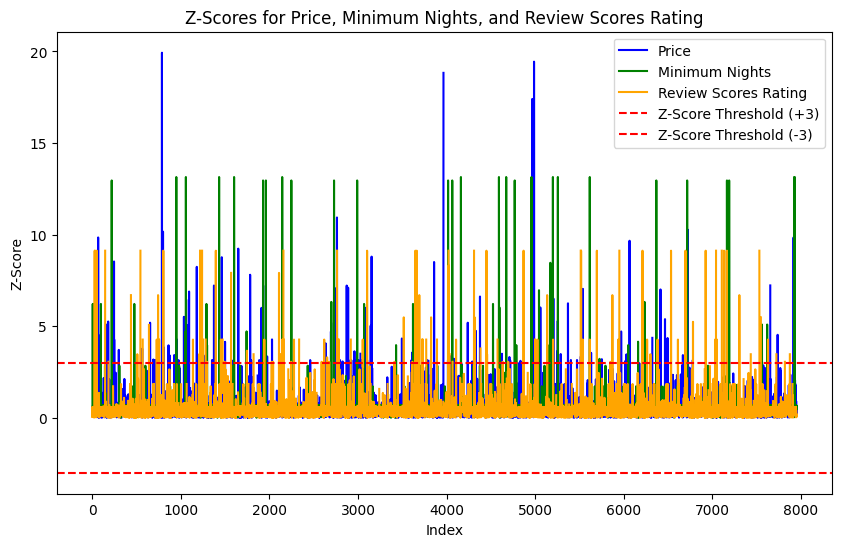

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers_z_score(dataframe, outlier_columns, threshold=3):
    """
    Remove outliers from the DataFrame using Z-Score method and store them in a new DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    outlier_columns (list): List of columns to check for outliers.
    threshold (float): Z-score threshold for detecting outliers (default is 3).

    Returns:
    pd.DataFrame: DataFrame without outliers.
    pd.Series: Series with the number of outliers detected per column.
    """
    # Standardizing (z-scoring) the data for outlier detection
    z_scores = np.abs((dataframe[outlier_columns] - dataframe[outlier_columns].mean()) / dataframe[outlier_columns].std())

    # Detecting outliers with a z-score threshold
    outliers = z_scores > threshold

    # Number of outliers per column
    outliers_per_column = outliers.sum()

    # Displaying the number of outliers per column
    print("Number of outliers per column:")
    print(outliers_per_column)

    # Remove outliers from the original DataFrame
    dataframe_no_outliers = dataframe[~outliers.any(axis=1)]

    # Plotting the z-scores with colors for each property
    plt.figure(figsize=(10, 6))

    # Plot each property with a different color
    plt.plot(z_scores['price'], label='Price', color='blue')
    plt.plot(z_scores['minimum_nights'], label='Minimum Nights', color='green')
    plt.plot(z_scores['review_scores_rating'], label='Review Scores Rating', color='orange')

    # Add z-score threshold line at the specified threshold
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Z-Score Threshold (+{threshold})')
    plt.axhline(y=-threshold, color='red', linestyle='--', label=f'Z-Score Threshold (-{threshold})')

    # Add labels and title
    plt.title('Z-Scores for Price, Minimum Nights, and Review Scores Rating')
    plt.xlabel('Index')
    plt.ylabel('Z-Score')

    # Add legend to show which color represents which property
    plt.legend()

    # Show the plot
    plt.show()

    return dataframe_no_outliers, outliers_per_column

listings_no_outliers_Z, outliers_per_column = remove_outliers_z_score(listings, outlier_columns)


Calculating summary statistics after dropping outliers according to IQR method

In [25]:
#IQR
display_summary_statistics(listings_no_outliers_IQR, numerical_features)

#Z Score
display_summary_statistics(listings_no_outliers_Z, numerical_features)

Summary Statistics:
             price  minimum_nights  maximum_nights  review_scores_rating
count  4176.000000     4176.000000     4176.000000           4176.000000
mean    180.780651        1.919061      427.252395              4.823599
std     106.017110        1.080989      423.236575              0.158338
min      19.000000        1.000000        2.000000              4.310000
25%     102.000000        1.000000       35.000000              4.740000
50%     155.000000        2.000000      365.000000              4.860000
75%     239.000000        2.000000      730.000000              4.950000
max     489.000000       11.000000     1125.000000              5.000000
Summary Statistics:
             price  minimum_nights  maximum_nights  review_scores_rating
count  7303.000000     7642.000000     7642.000000           6261.000000
mean    202.873340       12.461790      510.685554              4.803311
std     148.844043       15.053798      432.007439              0.227240
min      19

Visualizing after outlier removal using IQR

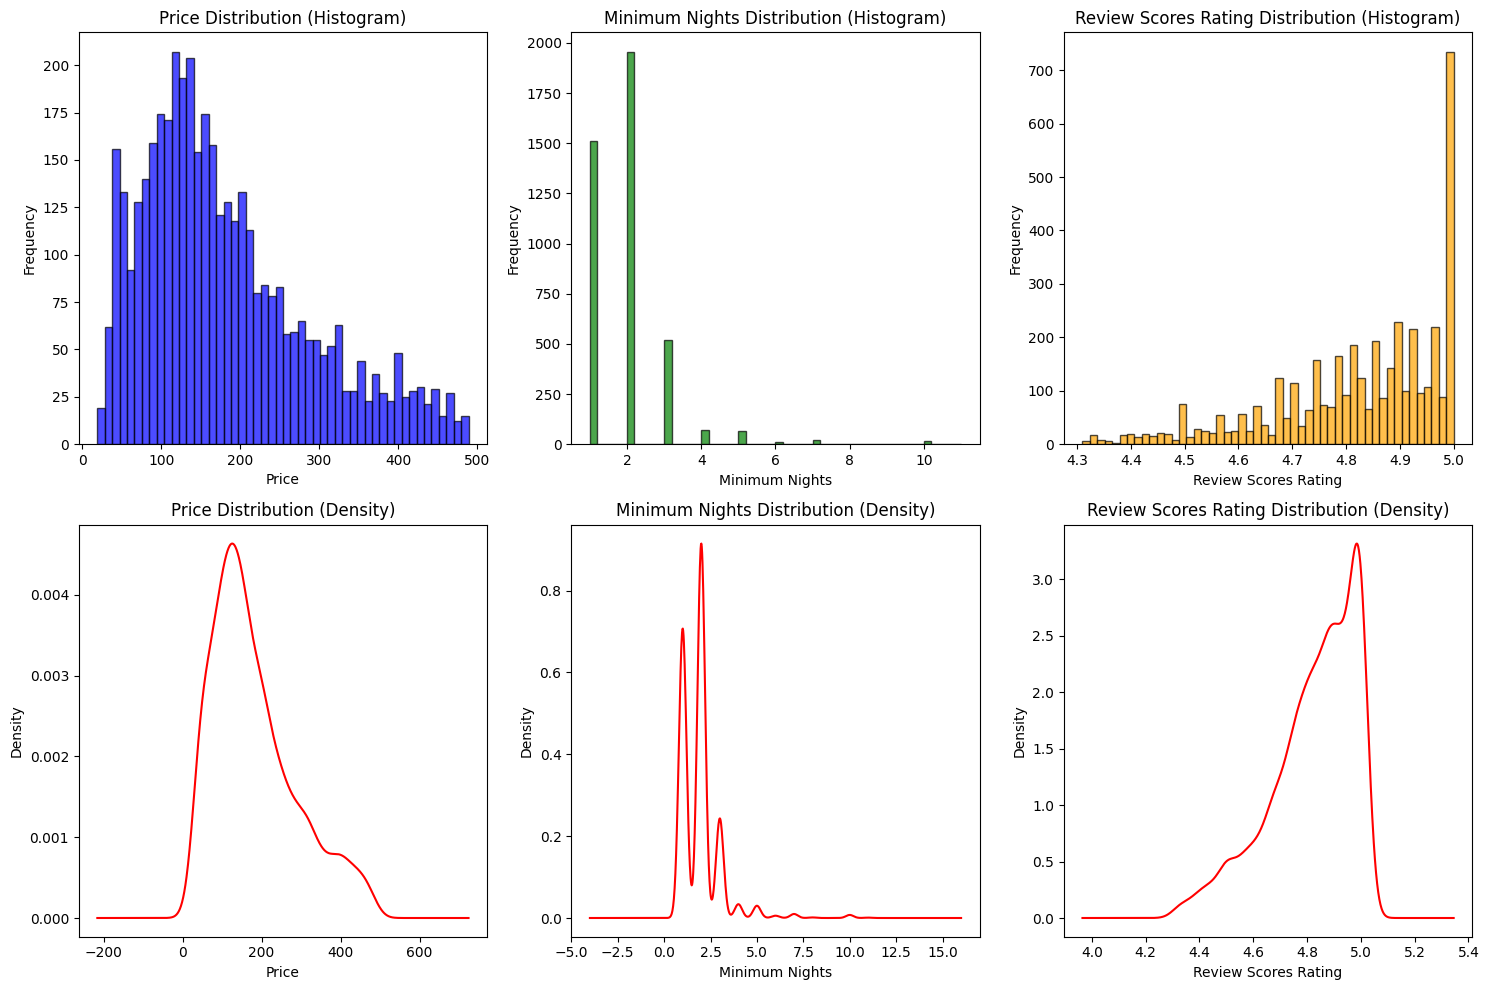

In [26]:
plot_numerical_distributions(listings_no_outliers_IQR)

Visualizing after outlier removal using Z Score

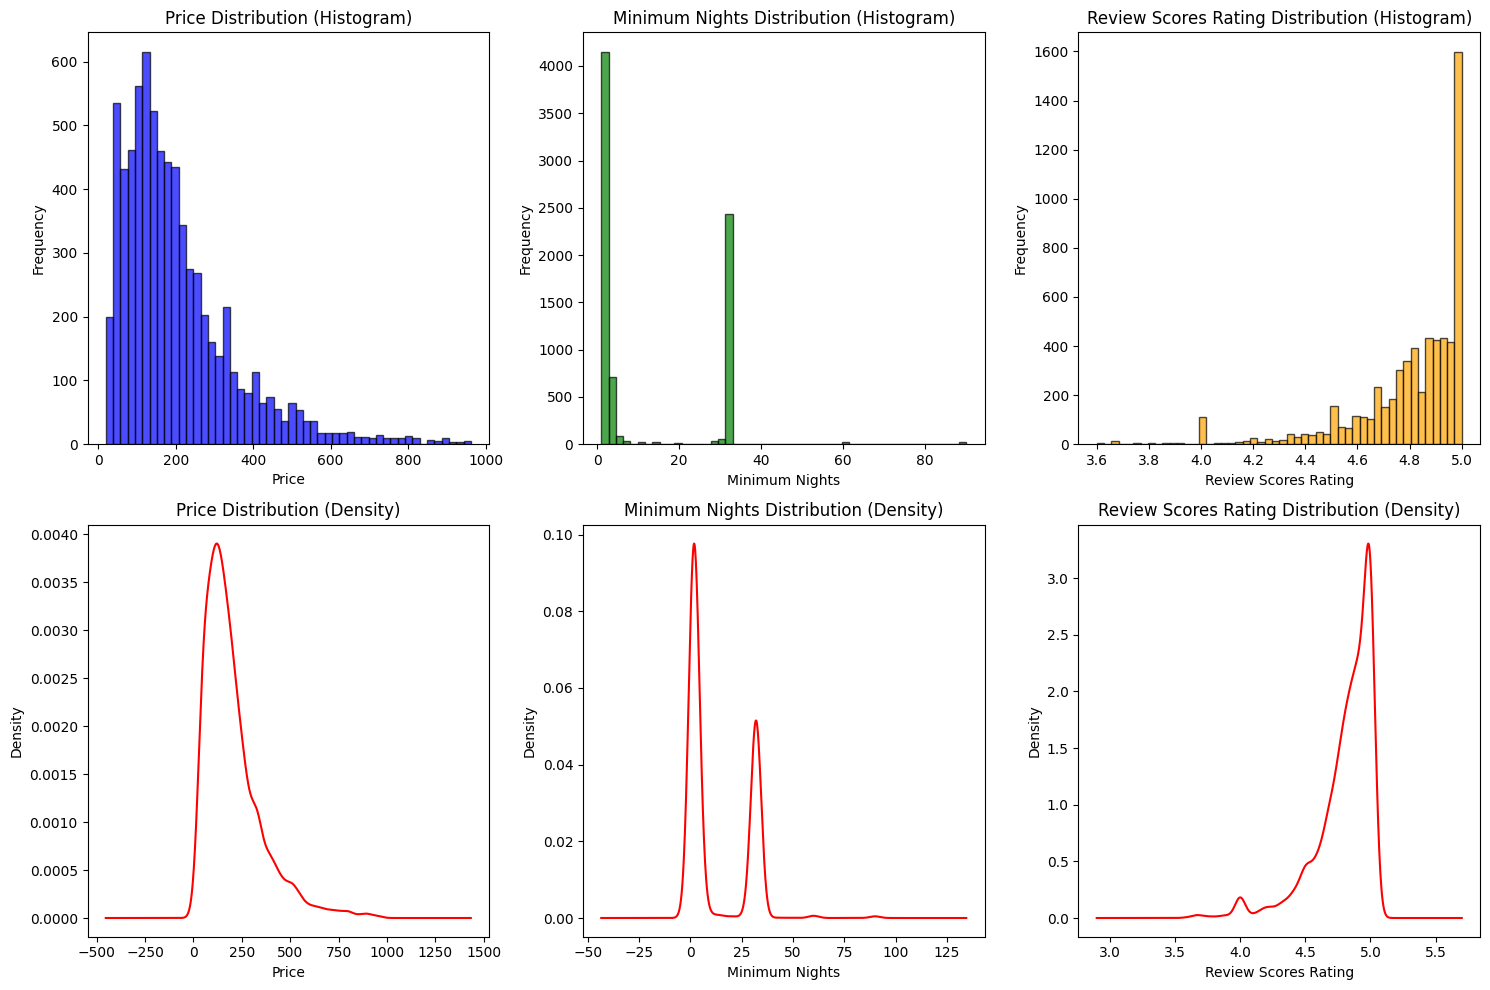

In [27]:
plot_numerical_distributions(listings_no_outliers_Z)

# Text Length

Create a new feature that measures the length of each review (number of words or characters). Determine if the length of a review correlates with its sentiment or the review scores.

<ipython-input-28-4408de321258>:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6503 entries, 0 to 6502
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   listing_id               6503 non-null   int64  
 1   avg_review_length_words  6503 non-null   float64
 2   review_scores_rating     6503 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 152.5 KB
None
Correlation between average review length and review score:
                         avg_review_length_words  review_scores_rating
avg_review_length_words                 1.000000             -0.192864
review_scores_rating                   -0.192864              1.000000


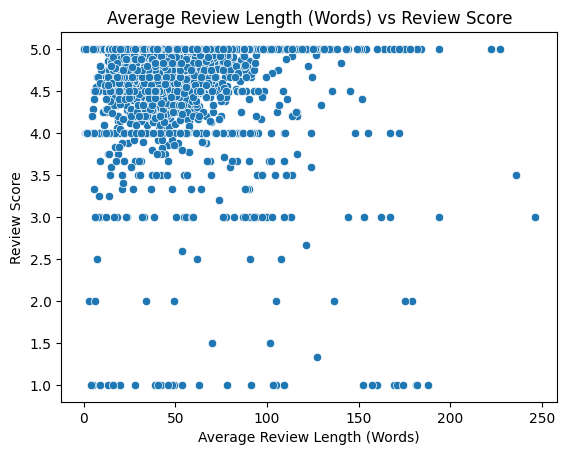

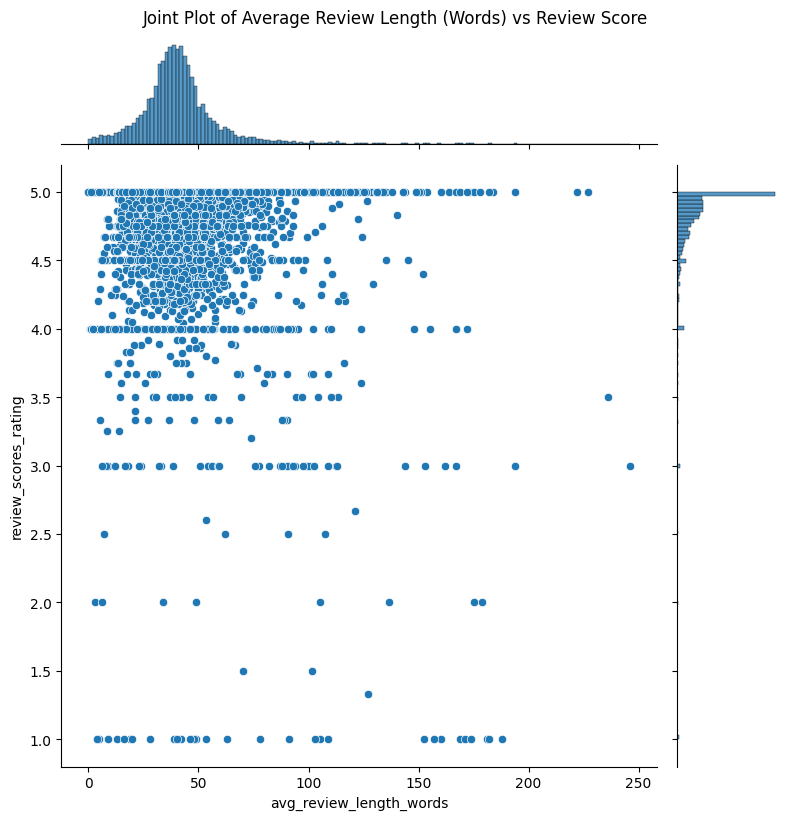

In [28]:
# Duplicate the 'id' column and name it 'listing_id' in listing dataset
listings['listing_id'] = listings['id']

# Fill missing values in the 'comments' column with an empty string
reviews['comments'] = reviews['comments'].fillna('')

# Define a function to clean HTML tags and special characters from the comments
def clean_text(text):
    # Ensure that the text is a string
    if not isinstance(text, str):
        return text

    # Remove HTML tags
    if '<' in text or '>' in text:  # Check if it contains HTML-like tags
        text = BeautifulSoup(text, "html.parser").get_text()

    # Remove special characters (keeping only letters, numbers, and basic punctuation)
    text = re.sub(r'[^A-Za-z0-9.,!?\'\s]', '', text)

    return text

# Apply the cleaning function to the 'comments' column
reviews['comments'] = reviews['comments'].apply(clean_text)

# Calculate the length of each review (both in words and characters)
reviews['review_length_words'] = reviews['comments'].apply(lambda x: len(str(x).split()))
reviews['review_length_chars'] = reviews['comments'].apply(lambda x: len(str(x)))

# Calculate the sentiment polarity of each review
reviews['sentiment'] = reviews['comments'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Group by 'listing_id' and calculate the average review length (in words) for each listing
avg_review_length = reviews.groupby('listing_id')['review_length_words'].mean().reset_index()
avg_review_length.columns = ['listing_id', 'avg_review_length_words']

# Merge the average review length with the cumulative review score from the 'listings' dataset
merged_data = avg_review_length.merge(listings[['listing_id', 'review_scores_rating']], on='listing_id', how='left')

# Drop any rows where review length or review score is missing
merged_data = merged_data.dropna(subset=['avg_review_length_words', 'review_scores_rating'])

# Display the merged data information
print(merged_data.info())

# Calculate the correlation between the average review length and the review score
correlation = merged_data[['avg_review_length_words', 'review_scores_rating']].corr()
print("Correlation between average review length and review score:")
print(correlation)

# Visualize the correlation using a scatter plot
sns.scatterplot(x='avg_review_length_words', y='review_scores_rating', data=merged_data)
plt.title('Average Review Length (Words) vs Review Score')
plt.xlabel('Average Review Length (Words)')
plt.ylabel('Review Score')
plt.show()

# Joint plot to show correlation between average review length and review score
sns.jointplot(x='avg_review_length_words', y='review_scores_rating', data=merged_data, kind='scatter', height=8)
plt.suptitle('Joint Plot of Average Review Length (Words) vs Review Score', y=1.02)
plt.show()


# Keyword Extraction

Identify and count the occurrence of specific keywords (e.g., "clean," "comfortable," "noisy") in the reviews. Generate new features based on the presence of these keywords, which might influence guest satisfaction

In [29]:
# Define positive and negative keywords
positive_keywords = ["great", "clean", "nice", "comfortable", "friendly", "spacious", "amazing", "fabulous"]
negative_keywords = ["uncomfortable", "noisy", "bad", "dirty", "terrible", "unpleasant", "poor"]

# Function to count keyword occurrences in a review, handling NaN values
def count_keywords(review, keywords):
    # Convert the review to a string to avoid errors
    review = str(review).lower()
    # Count occurrences of each keyword
    keyword_counts = {keyword: review.count(keyword) for keyword in keywords}

    return keyword_counts

# Apply the function and convert the result to a DataFrame for positive keywords
positive_keyword_counts_df = reviews["comments"].apply(lambda x: pd.Series(count_keywords(x, positive_keywords)))

# Add the 'positive_' prefix to the column names for positive keywords
positive_keyword_counts_df.columns = ['positive_' + col for col in positive_keyword_counts_df.columns]

# Join the positive keyword counts with the original DataFrame
reviews = reviews.join(positive_keyword_counts_df)

# Apply the function and convert the result to a DataFrame for negative keywords
negative_keyword_counts_df = reviews["comments"].apply(lambda x: pd.Series(count_keywords(x, negative_keywords)))

# Add the 'negative_' prefix to the column names for negative keywords
negative_keyword_counts_df.columns = ['negative_' + col for col in negative_keyword_counts_df.columns]

# Join the negative keyword counts with the original DataFrame
reviews = reviews.join(negative_keyword_counts_df)

# Aggregate keyword counts for each motel
aggregated_reviews = reviews.groupby('listing_id').sum().reset_index()

# Save aggregated reviews to a CSV file
aggregated_reviews.to_csv('aggregated_reviews.csv', index=False)

# List of columns to merge from 'aggregated_reviews'
columns_to_merge = [
    'listing_id', 'positive_great', 'positive_clean', 'positive_nice',
    'positive_comfortable', 'positive_friendly', 'positive_spacious',
    'positive_amazing', 'positive_fabulous', 'negative_uncomfortable',
    'negative_noisy', 'negative_bad', 'negative_dirty', 'negative_terrible',
    'negative_unpleasant', 'negative_poor'
]

# Select only the necessary columns from aggregated_reviews
aggregated_selected = aggregated_reviews[columns_to_merge]

# Merge using 'listing_id' from 'aggregated_reviews' and 'id' from 'listings'
listings = listings.merge(aggregated_selected, left_on='id', right_on='listing_id', how='left')

# Fill NaN values with 0 (in case some motels have no reviews)
listings = listings.fillna(0)

listings.to_csv('listings_with_keywords.csv', index=False)

# Select specific columns to display
columns_to_display = ['id', 'name', 'review_scores_rating'] + [f'positive_{kw}' for kw in positive_keywords] + [f'negative_{kw}' for kw in negative_keywords]
result = listings[columns_to_display]

# Debugging: Print the final result DataFrame
print("Final result DataFrame:")
print(result.head())

# Save the result to a CSV file
result.to_csv('result_keywords.csv', index=False)


Final result DataFrame:
                    id                                               name  \
0             16757056                     Heart of Chicago 2BD + Parking   
1             48112045  West Town Chicago Apt near Metra and United Ce...   
2  1089958767588000931                    Nice 2bd 1ba w/ gated entrance!   
3             24694181                                         Talman Ave   
4   639920368906600737      Historic brownstone in the heart of Old Town!   

   review_scores_rating  positive_great  positive_clean  positive_nice  \
0                  4.78           124.0           102.0           46.0   
1                  4.73            37.0            18.0           15.0   
2                  5.00             1.0             1.0            0.0   
3                  4.93            36.0            14.0            6.0   
4                  4.67            11.0             2.0            0.0   

   positive_comfortable  positive_friendly  positive_spacious  \
0  